In [1]:
using QuantEcon, CairoMakie, CUDA

In [2]:
CUDA.name(CUDA.device())

"NVIDIA GeForce RTX 3080 Ti Laptop GPU"

In [3]:
max_threads_per_block = CUDA.attribute(CUDA.device(), CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)

1024

In [17]:
function params(;nk = 101)
    
    p = (α = 0.33, # Capital share
         β = 0.9, # Discount factor
         A = 10.0, # TFP
         δ = 0.1, # Depreciation rate
         kmin = 1e-4, # Minimum capital
         kmax = 1000, # Maximum capital
         θ = 3.0, # Grid expansion parameter
         γ = 2.0, # Risk aversion
         kgrid = zeros(Float32, nk), # Capital grid
         maxiter = 100000, # Maximum number of iterations
         tol = 1e-6) # Tolerance

    # Create capital grid
    kgrid = LinRange(p.kmin, p.kmax, nk)
    temp_grid = LinRange(0, 1, nk)
    kgrid = p.kmin .+ (p.kmax - p.kmin) * temp_grid.^p.θ
    
    #Return new NamedTuple
    p = (p..., kgrid = kgrid)
    
    return p
end

function gpu_test(grid)
    return grid .+ 1 
end

p = params(nk = 1024)
kgrid_d = CuArray(p.kgrid)
@time gpu_test(kgrid_d)

  0.019352 seconds (45.17 k allocations: 3.302 MiB, 99.19% compilation time)


1024-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
    1.0001
    1.0001009340563032
    1.0001074724504246
    1.0001252195201829
    1.0001597796033965
    1.000216757037884
    1.0003017561614636
    1.0004203813119537
    1.000578236827173
    1.0007809270449395
    ⋮
  977.7225771548534
  980.6122867548496
  983.5076903620693
  986.4087935808506
  989.3156020155309
  992.2281212704481
  995.1463569499402
  998.0703146583448
 1001.0

In [5]:
cons_d = p.A .* kgrid_d.^p.α .+ (1 - p.δ) .* kgrid_d .- kgrid_d'

1024×1024 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
   0.47862     0.47862     0.478619  …  -98.9359  -99.2283  -99.5213
   0.478768    0.478768    0.478767     -98.9358  -99.2282  -99.5211
   0.479798    0.479798    0.479797     -98.9347  -99.2271  -99.5201
   0.482573    0.482572    0.482572     -98.932   -99.2244  -99.5173
   0.487884    0.487884    0.487884     -98.9267  -99.219   -99.512
   0.496394    0.496394    0.496394  …  -98.9181  -99.2105  -99.5035
   0.508565    0.508565    0.508564     -98.906   -99.1984  -99.4913
   0.524622    0.524622    0.524621     -98.8899  -99.1823  -99.4753
   0.544555    0.544555    0.544554     -98.87    -99.1624  -99.4553
   0.56816     0.568159    0.568159     -98.8464  -99.1388  -99.4317
   ⋮                                 ⋱                      
 133.26      133.26      133.26      …   33.8453   33.5529   33.26
 133.564     133.564     133.564         34.1496   33.8572   33.5643
 133.869     133.869     133.869         34.4545   34.1621  

In [6]:
function gpu_unpack(p::NamedTuple)

    # Create CuArrays
    V_d = CuArray{Float64}(zeros(length(p.kgrid)))
    Vnew_d = CuArray{Float64}(zeros(length(p.kgrid),length(p.kgrid)))
    Vmax_d = CuArray{Float64}(zeros(length(p.kgrid)))
    pol_d = CuArray{Int64}(undef, length(p.kgrid))

    # Get params
    maxiter = p.maxiter
    tol = p.tol
    γ = p.γ
    β = p.β
    nk = length(p.kgrid)
    
    # Initialise consumption
    cons_d = p.A .* kgrid_d.^p.α .+ (1 - p.δ) .* kgrid_d .- kgrid_d'
    
    # Run VFI
    gpu_vfi!(V_d, Vnew_d, Vmax_d, cons_d, pol_d, kgrid_d; maxiter = maxiter, tol = tol, γ = γ, β = β, nk = nk)

    return V_d, pol_d, kgrid_d
end

gpu_unpack (generic function with 1 method)

In [30]:
function gpu_vfi!(V, Vnew, Vmax, cons, pol, grid; maxiter, tol, γ, β, nk)
    error = tol + 1.0
    iter = 0
    pos_c = cons .> 0
    cons[.!pos_c] .= 1e-10
    c = (γ == 1.0 ? log.(cons) : (cons.^(1 - γ) .- 1) ./ (1 - γ))
    while ((error > tol) && (iter < maxiter))
        Vnew = c .+ β .* V'
        Vnew = reshape(Vnew, nk*nk, 1)
        block_size = max_threads_per_block
        num_blocks = ceil(Int, nk / block_size)
        @cuda threads=block_size blocks=num_blocks max_kernel!(Vnew, Vmax, pol, nk)
        error = maximum(abs.(Vmax .- V))
        V .= Vmax
        iter += 1
    end
    return V, pol
end

gpu_vfi! (generic function with 1 method)

In [31]:
function max_kernel!(Vnew, Vmax, pol, nk)
    idx = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if idx <= nk
        row_start = (idx - 1) * nk
        max_val = Vnew[row_start + idx]
        max_pos = idx
        for j in idx+1:nk
            if Vnew[row_start + j] > max_val
                max_val = Vnew[row_start + j]
                max_pos = j
            elseif Vnew[row_start + j] < max_val
                break
            end
        end
        Vmax[idx] = max_val
        pol[idx] = max_pos
    end
    return
end

max_kernel! (generic function with 1 method)

In [32]:
psmall = params(nk = 128)
pbig = params(nk = 1024)

#@time begin
#    out_v_d_s, out_pol_d_s, out_grid_d_s = gpu_unpack(psmall)
#end

@time begin
    out_v_d_b, out_pol_d_b, out_grid_d_b = gpu_unpack(pbig)
end

  0.754353 seconds (275.80 k allocations: 26.061 MiB, 20.67% compilation time)


([9.989977184283758, 9.989977184274375, 9.989977184208692, 9.98997718403041, 9.98997718368323, 9.989977183110852, 9.989977182256979, 9.989977181065308, 9.98997717947954, 9.989977177443375  …  9.581330104957555, 9.52383548476888, 9.447862645236587, 9.342798426348175, 9.187977422033875, 8.937088396521972, 8.460496531543674, 7.204646550496741, -5.304386559015588, -9.999999998999995e10], [1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024  …  1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024], [0.0001, 0.00010093405630307202, 0.00010747245042457614, 0.00012521952018294444, 0.00015977960339660902, 0.00021675703788400202, 0.0003017561614635555, 0.00042038131195370153, 0.0005782368271728723, 0.0007809270449395001  …  973.8385559577428, 976.7225771548534, 979.6122867548496, 982.5076903620693, 985.4087935808506, 988.3156020155309, 991.2281212704481, 994.1463569499402, 997.0703146583448, 1000.0])

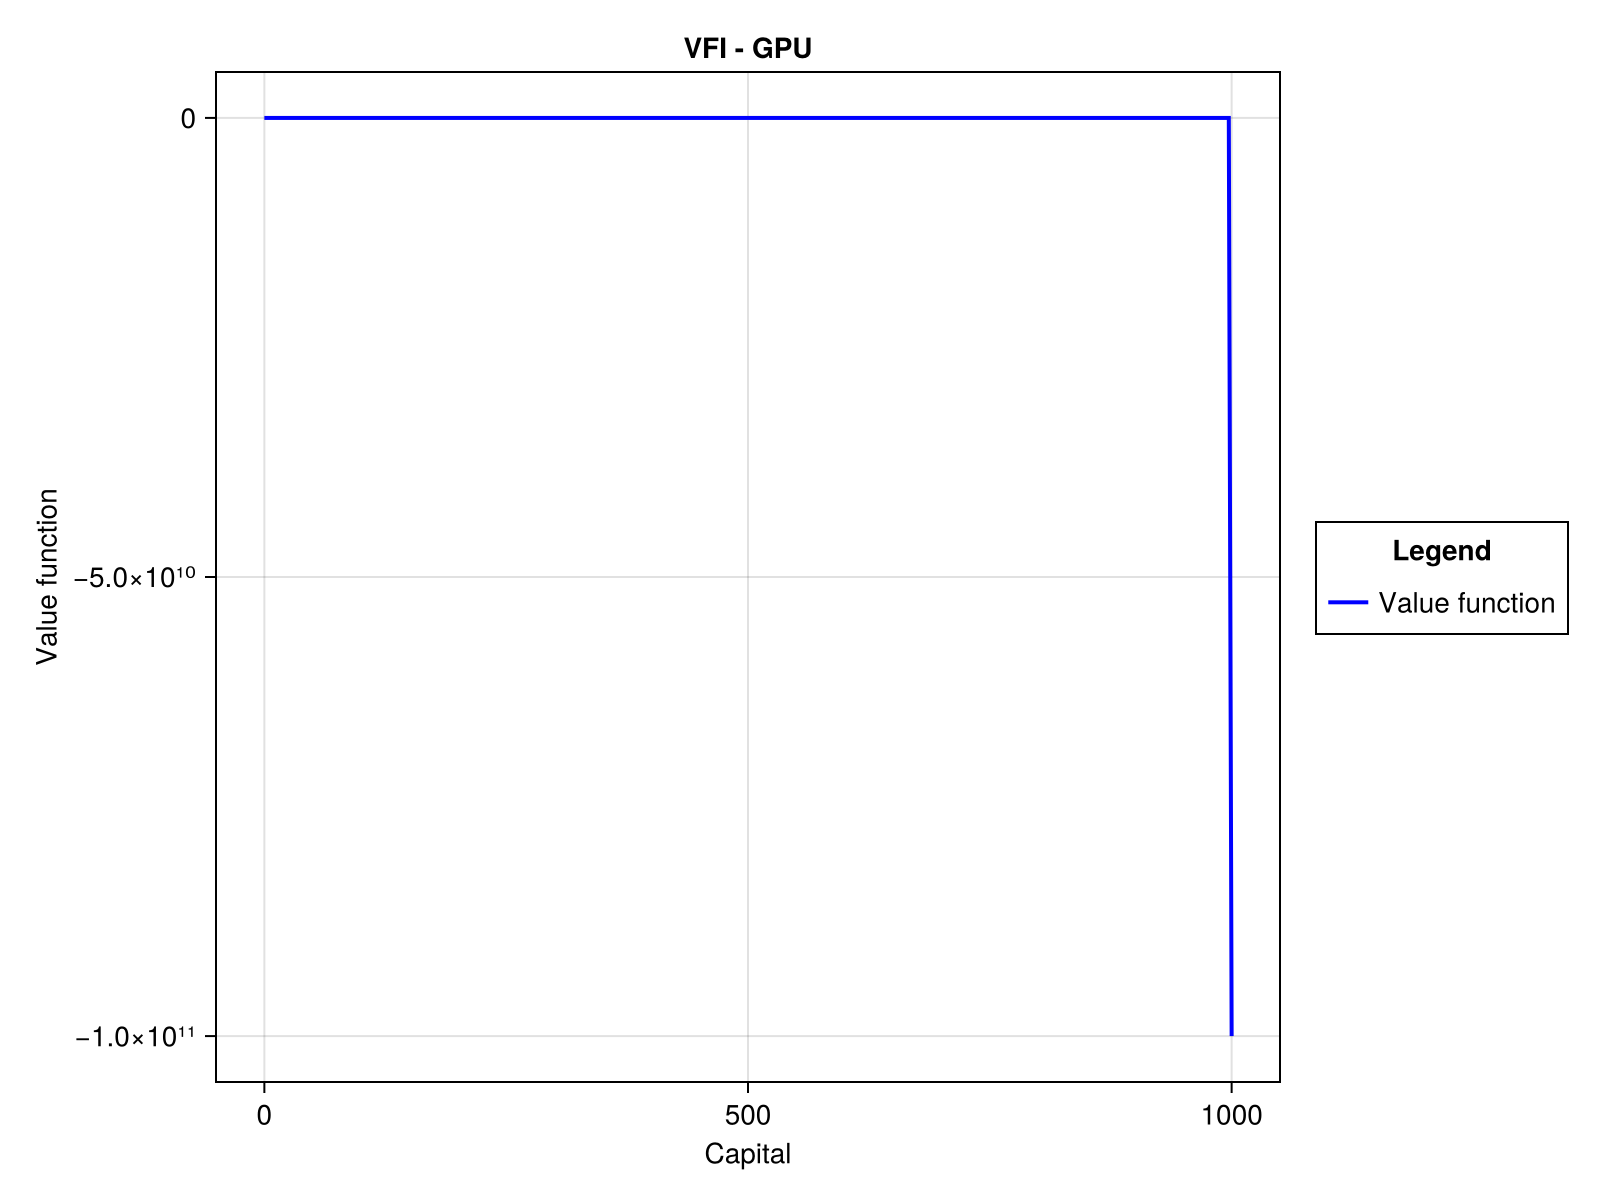

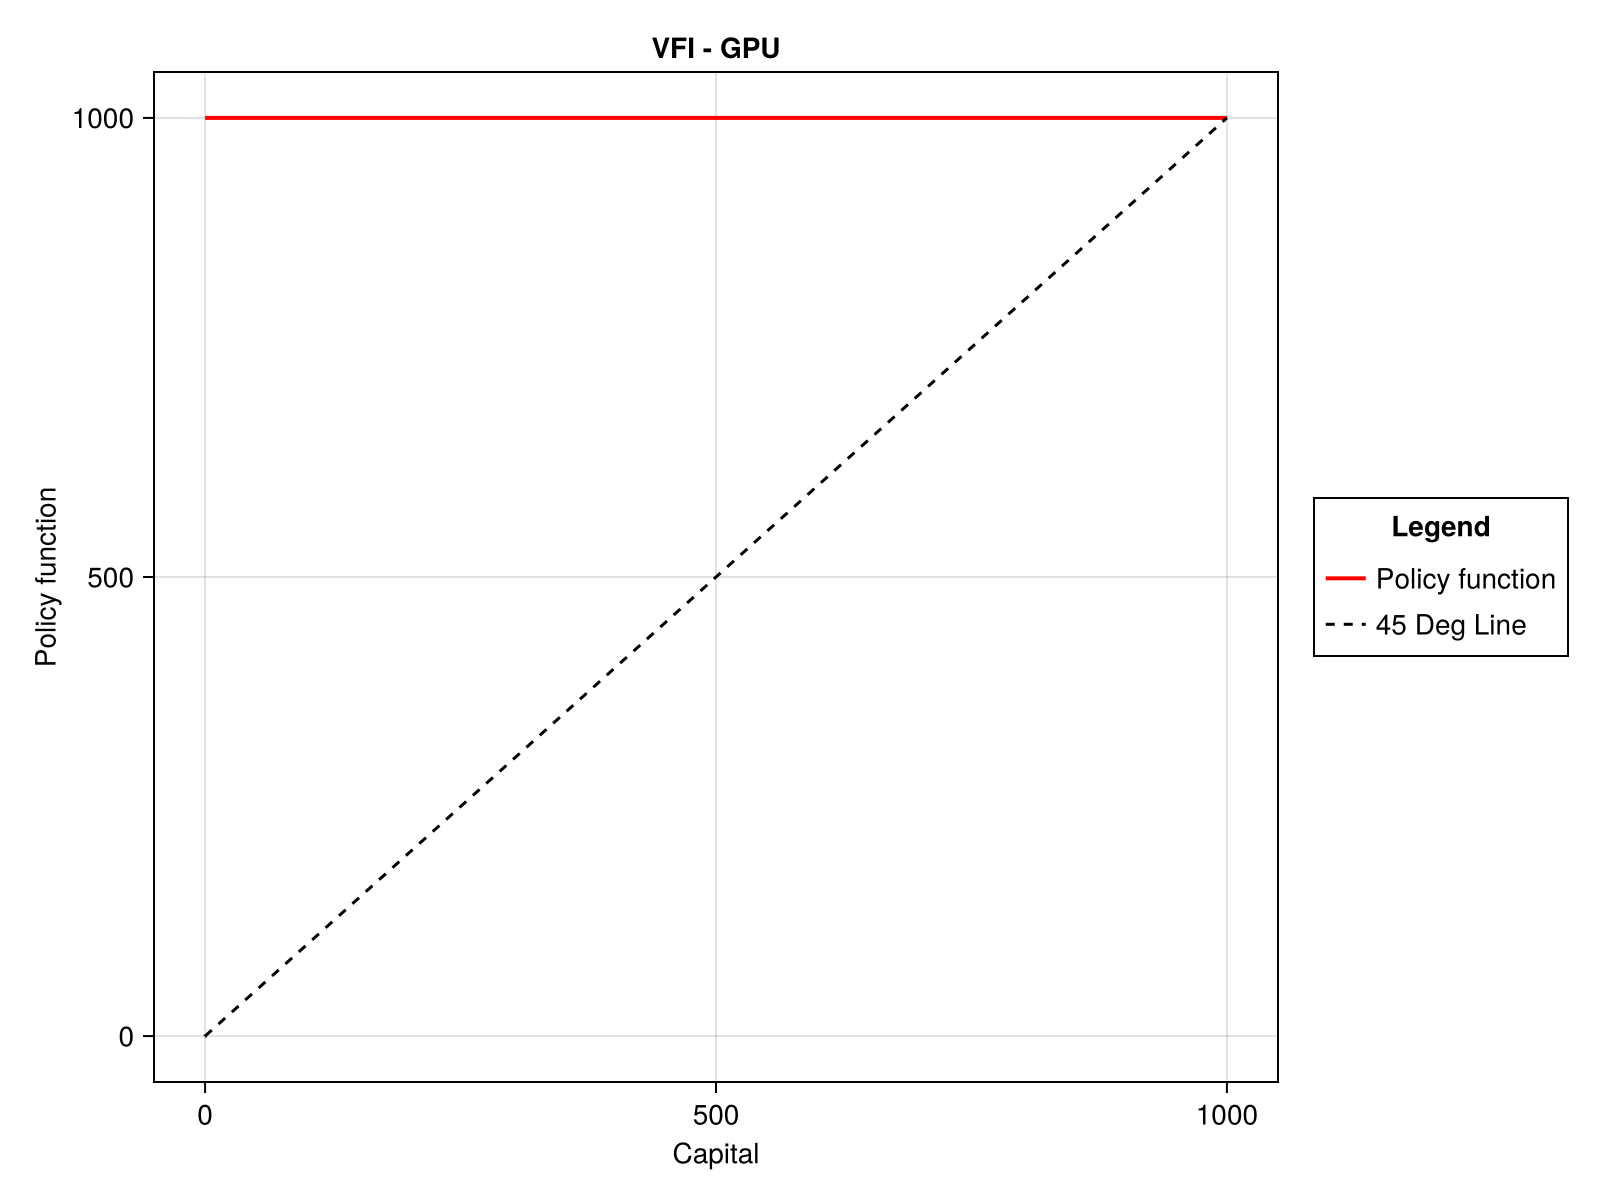

In [33]:
out_v_h = Array(out_v_d_b)
out_pol_h = Array(out_pol_d_b)
out_grid_h = Array(out_grid_d_b)

figv = Figure(size = (800,600))
axv = Axis(figv[1,1], xlabel = "Capital", ylabel = "Value function", title = "VFI - GPU")
lines!(axv, out_grid_h, out_v_h, color = :blue, label = "Value function", linewidth = 2)
legendp = Legend(figv[1,2], axv, "Legend", orientation = :vertical)
display(figv)

figp = Figure(size = (800,600))
axp = Axis(figp[1,1], xlabel = "Capital", ylabel = "Policy function", title = "VFI - GPU")
lines!(axp, out_grid_h, out_grid_h[out_pol_h], color = :red, linewidth = 2, label = "Policy function")
lines!(axp, out_grid_h, out_grid_h, color = :black, label = "45 Deg Line", linestyle = :dash)
legendp = Legend(figp[1,2], axp, "Legend", orientation = :vertical)
figp